# Example: Sizing a plant to meet constant electrical load

##
**Imports**

Install hydesign if needed.
Import basic libraries. 
Import HPP model assembly class.
Import the examples file path.

In [1]:
# Detect if running in Kaggle
import os 
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
    mypaths = !python -c "import sysconfig; print(sysconfig.get_paths()['purelib'])"
    mypath = mypaths[0]
    !pip install trash-cli
    !trash $mypath/numpy*
    !pip install --upgrade numpy
    !pip install finitediff
    import os
    os.kill(os.getpid(), 9)

In [2]:
# Install hydesign if needed
import importlib
if not importlib.util.find_spec("hydesign"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/hydesign.git   

In [3]:
import pandas as pd
import numpy as np
from hydesign.hpp_assembly_constantoutput import hpp_model
from hydesign.examples import examples_filepath
import matplotlib.pyplot as plt

C:\Users\mikf\Anaconda3\envs\hd2\lib\site-packages\pyoptsparse\pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


## Evaluation
First we evaluate a specific configuration. The minimum load constraint is implemented as a penalty, so not meeting it will result in severly penalized financial metrics as seen below:

In [4]:
examples_sites = pd.read_csv(f'{examples_filepath}examples_sites.csv', index_col=0)
name = 'France_good_wind'
ex_site = examples_sites.loc[examples_sites.name == name]
longitude = ex_site['longitude'].values[0]
latitude = ex_site['latitude'].values[0]
altitude = ex_site['altitude'].values[0]
input_ts_fn = examples_filepath+ex_site['input_ts_fn'].values[0]
sim_pars_fn = examples_filepath+ex_site['sim_pars_fn'].values[0]
H2_demand_fn = examples_filepath+ex_site['H2_demand_col'].values[0]

PPA = 40 # Euro/MWh
hpp = hpp_model(
    latitude,
    longitude,
    altitude,
    num_batteries = 10,
    work_dir = './',
    sim_pars_fn = sim_pars_fn,
    input_ts_fn = input_ts_fn,
    ppa_price=PPA,
    load_min=3, #MW
)
x=[35.0, 300.0, 10.0, 46, 7.0, 74, 25.0, 180.0, 1.0, 30, 7, 10.0]


Fixed parameters on the site
-------------------------------
longitude = -0.864258
latitude = 48.744116
altitude = 302.0


In [5]:
outs = hpp.evaluate(*x)

In [6]:
hpp.print_design(x, outs) 


Design:
---------------
clearance [m]: 35.000
sp [W/m2]: 300.000
p_rated [MW]: 10.000
Nwt: 46.000
wind_MW_per_km2 [MW/km2]: 7.000
solar_MW [MW]: 74.000
surface_tilt [deg]: 25.000
surface_azimuth [deg]: 180.000
DC_AC_ratio: 1.000
b_P [MW]: 30.000
b_E_h [h]: 7.000
cost_of_battery_P_fluct_in_peak_price_ratio: 10.000


NPV_over_CAPEX: 0.326
NPV [MEuro]: 184.641
IRR: 0.095
LCOE [Euro/MWh]: 30.604
CAPEX [MEuro]: 566.432
OPEX [MEuro]: 12.576
Wind CAPEX [MEuro]: 466.835
Wind OPEX [MEuro]: 12.243
PV CAPEX [MEuro]: 17.020
PV OPEX [MEuro]: 0.333
Batt CAPEX [MEuro]: 11.882
Batt OPEX [MEuro]: 0.000
Shared CAPEX [MEuro]: 70.696
Shared Opex [MEuro]: 0.000
penalty lifetime [MEuro]: 622.740
AEP [GWh]: 1739.424
GUF: 0.662
grid [MW]: 300.000
wind [MW]: 460.000
solar [MW]: 74.000
Battery Energy [MWh]: 210.000
Battery Power [MW]: 30.000
Total curtailment [GWh]: 10181.517
Awpp [km2]: 65.714
Apvp [km2]: 0.907
Plant area [km2]: 65.714
Rotor diam [m]: 206.013
Hub height [m]: 138.006
Number of batteries used i

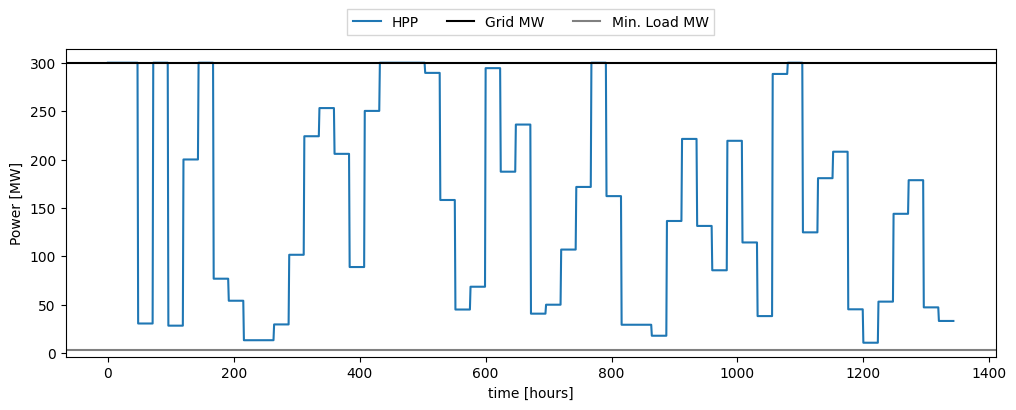

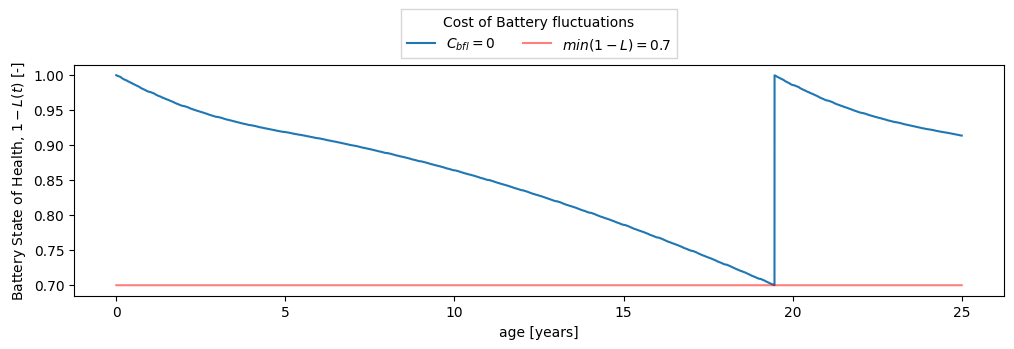

In [7]:
b_E_SOC_t = hpp.prob.get_val('ems.b_E_SOC_t')
b_t = hpp.prob.get_val('ems.b_t')
price_t = hpp.prob.get_val('ems.price_t')

wind_t = hpp.prob.get_val('ems.wind_t')
solar_t = hpp.prob.get_val('ems.solar_t')
hpp_t = hpp.prob.get_val('ems.hpp_t')
hpp_curt_t = hpp.prob.get_val('ems.hpp_curt_t')
grid_MW = hpp.prob.get_val('ems.G_MW')

n_days_plot = 14*4

plt.figure(figsize=[12,4])
plt.plot(hpp_t[:24*n_days_plot], label='HPP')
plt.axhline(grid_MW, label='Grid MW', color='k')
plt.axhline(hpp.prob['load_min'], label='Min. Load MW', color='grey')
plt.xlabel('time [hours]')
plt.ylabel('Power [MW]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=5, fancybox=0, shadow=0)
plt.show()

N_life = hpp.sim_pars['N_life']
life_h = N_life*365*24
age = np.arange(life_h)/(24*365)

SoH = np.copy(hpp.prob.get_val('battery_degradation.SoH'))
plt.figure(figsize=[12,3])
plt.plot( age, SoH, label=r'$C_{bfl}=0$')
plt.plot( age, 0.7*np.ones_like(age), label=r'$min(1-L) = 0.7$', color='r',alpha=0.5)
plt.xlabel('age [years]')
plt.ylabel(r'Battery State of Health, $1-L(t)$ [-]')
plt.legend(title='Cost of Battery fluctuations',
            loc='upper center', bbox_to_anchor=(0.5, 1.27),
            ncol=3, fancybox=0, shadow=0)
plt.show()  

## Sizing
To optimize the size of the different technologies in order to meet the load we can do a sizing optimization:

In [8]:
from hydesign.Parallel_EGO import get_kwargs, EfficientGlobalOptimizationDriver
import os

In [9]:
n_procs = int(os.cpu_count())

In [10]:
inputs = {
    'example': 9,
    'name': None,
    'longitude': None,
    'latitude': None,
    'altitude': None,
    'input_ts_fn': None,
    'sim_pars_fn': None,

    'opt_var': "NPV_over_CAPEX",
    'num_batteries': 10,
    'n_procs': n_procs - 1,
    'n_doe': 20,
    'n_clusters': 5,
    'n_seed': 0,
    'max_iter': 10,
    'final_design_fn': 'hydesign_design_0.csv',
    'npred': 3e4,
    'tol': 1e-6,
    'min_conv_iter': 3,
    'work_dir': './',
    'hpp_model': hpp_model,
    'PPA_price': 40,
    'load_min': 3, # MW
    }
kwargs = get_kwargs(inputs)

Selected example site:
---------------------------------------------------
case                                                 Europe
name                                      Denmark_good_wind
longitude                                          8.594398
latitude                                          56.227322
altitude                                               85.0
input_ts_fn      Europe/GWA3/input_ts_Denmark_good_wind.csv
sim_pars_fn                             Europe/hpp_pars.yml
price_fn                           Europe/2030-EL_PRICE.csv
price_col                                              DK_W
H2_demand_col                          Europe/H2_demand.csv
Name: 9, dtype: object


In [11]:
kwargs['variables'] = {
    'clearance [m]':
        #{'var_type':'design',
        #  'limits':[10, 60],
        #  'types':'int'
        #  },
        {'var_type':'fixed',
           'value': 35
           },
    'sp [W/m2]':
        #{'var_type':'design',
        # 'limits':[200, 359],
        # 'types':'int'
        # },
        {'var_type':'fixed',
           'value': 300
           }, 
    'p_rated [MW]':
        {'var_type':'design',
          'limits':[1, 10],
          'types':'int'
          },
        # {'var_type':'fixed',
        #  'value': 6
         # },
    'Nwt':
        {'var_type':'design',
          'limits':[0, 400],
          'types':'int'
          },
        # {'var_type':'fixed',
        #   'value': 200
        #   },
    'wind_MW_per_km2 [MW/km2]':
        #{'var_type':'design',
        #  'limits':[5, 9],
        #  'types':'float'
        #  },
         {'var_type':'fixed',
           'value': 7
           },
    'solar_MW [MW]':
        {'var_type':'design',
           'limits':[0, 400],
           'types':'int'
          },
        #{'var_type':'fixed',
        #  'value': 20
        #  },
    'surface_tilt [deg]':
        # {'var_type':'design',
        #   'limits':[0, 50],
        #   'types':'float'
        #   },
        {'var_type':'fixed',
          'value': 25
          },
    'surface_azimuth [deg]':
        # {'var_type':'design',
        #   'limits':[150, 210],
        #   'types':'float'
        #   },
        {'var_type':'fixed',
          'value': 180
          },
    'DC_AC_ratio':
        # {'var_type':'design',
        #   'limits':[1, 2.0],
        #   'types':'float'
        #   },
        {'var_type':'fixed',
          'value':1.6,
          },
    'b_P [MW]':
        {'var_type':'design',
           'limits':[0, 100],
           'types':'int'
          },
        #{'var_type':'fixed',
        #  'value': 50
        #  },
    'b_E_h [h]':
        {'var_type':'design',
           'limits':[1, 10],
           'types':'int'
          },
        #{'var_type':'fixed',
        #  'value': 6
        #  },
    'cost_of_battery_P_fluct_in_peak_price_ratio':
        {'var_type':'design',
          'limits':[0, 20],
          'types':'float'
          },
#         {'var_type':'fixed',
#           'value': 10},
    }


In [12]:
EGOD = EfficientGlobalOptimizationDriver(**kwargs)
EGOD.run()
result = EGOD.result





Sizing a HPP plant at Denmark_good_wind:


Fixed parameters on the site
-------------------------------
longitude = 8.594398
latitude = 56.227322
altitude = 85.0



Initial 20 simulations took 2.36 minutes
  Current solution -NPV_over_CAPEX = 2.554E-03
  Current No. model evals: 20

Update sm and extract candidate points took 0.2 minutes
Check-optimal candidates: new 17 simulations took 2.35 minutes
  Current solution -NPV_over_CAPEX = -3.365E-02
  Current No. model evals: 36
  rel_yopt_change = -1.08E+00
Iteration 1 took 2.56 minutes

Update sm and extract candidate points took 0.19 minutes
Check-optimal candidates: new 16 simulations took 2.1 minutes
  Current solution -NPV_over_CAPEX = -3.597E-02
  Current No. model evals: 50
  rel_yopt_change = -6.44E-02
Iteration 2 took 2.29 minutes

Update sm and extract candidate points took 0.19 minutes
Check-optimal candidates: new 15 simulations took 2.08 minutes
  Current solution -NPV_over_CAPEX = -3.597E-02
  Current No. model evals: 6